$$
{\huge \text{Model selection bias: a simple simulation}}
$$

$$
{\scriptsize \text{Massimo Pierini, 2025}}
$$

It is well known that model selection procedures invalidate classical inference on the parameters of the selected model (Berk 2010, 2013; Leeb 2005; Pötscher 1991).

The aim of this notebook is to provide a simple and fully reproducible simulation to help understand and verify what happens as a result of a model selection procedure.

# INTRODUCTION

In this simple simulation, we'll experimentally verify that a model selection procedure distorts the distribution of the estimators so that the classical inference cannot be safely applied anymore to the selected model.

We'll use a modified version of the "Simulations of Model-Selection", section 4 of "Statistical Inference After Model Selection" (Berk 2010).

# DEFINITION

For this simulation, the full regression model takes the form of

\begin{equation}
y_i = \beta_0 + \beta_w w_i + \beta_x x_i + \beta_z z_i + \varepsilon_i
\end{equation}
where

\begin{equation}
\left\{
\begin{array}{l}
\beta_0 = 3.0
\\
\beta_w = 0.0
\\
\beta_x = 0.50
\\
\beta_z = 0.25
\end{array}
\right.
\end{equation}

and $\varepsilon_i \overset{iid}{\sim} N(0, \sigma_\varepsilon^2)$.

Because the parameter $\beta_w = 0$ in equation $(1)$, many would refer to a submodel that excluded $W$ as
the “correct” model. But equation $(1)$ is also correct as long at $\beta_w = 0$ is
allowed. Therefore, we will use the adjective “preferred” for the model with
$W$ excluded. The full model and the preferred model will generate the same
conditional expectations for the response. The smaller model is preferred
because it is simpler and uses up one less degree of freedom (Berk 2009).

All three predictors are drawn at random from a multivariate normal
distribution with null means.

The
variances and covariances are set as follows: 
$\sigma_\varepsilon^2 = 10.0$, 
$\sigma_w^2 = 5.0$, 
$\sigma_x^2 = 6.0$,
$\sigma_z^2 = 7.0$, 
$\sigma_{w,x} = 4.0$, 
$\sigma_{w,z} = 5.0$, 
and $\sigma_{x,z} = 5.0$,
therefore leading to the following covariance matrix $\Sigma$

\begin{equation}
\Sigma = 
\begin{bmatrix}
5 & 4 & 5
\\
4 & 6 & 5
\\
5 & 5 & 7
\end{bmatrix}
\end{equation}

The sample size will be 200.

10,000 samples will be drawn, forward stepwise regression minimizing AIC applied to each, and sampling distributions will be constructed from the final models selected. In addition to plotting estimated regression coeﬃcients, conventional t-values will be plotted. The usual null hypothesis will be assumed; each regression coeﬃcient has
a population value $0.0$. 

A distribution of t-values is more informative than
a distribution of regression coeﬃcients because it takes the regression coeﬃcients and their standard errors into account (Berk 2009).

# SIMULATIONS

First of all, let's make the needed imports

In [1]:
import numpy as np
import pandas as pd
import scipy.stats as sps
import matplotlib.pyplot as plt
import statsmodels.api as sm
import seaborn as sns
from tqdm.notebook import tqdm

and define the "true" coefficients, variances, covariances, and sample size. We'll set a seed (`random_state`) to ensure reproducibility.

In [2]:
# true model coefficients
beta0 = 3.0
betaw = 0.0
betax = .50
betaz = .25
N = 200
# random errors distribution
epsilon = sps.norm(loc=0, scale=np.sqrt(10.0))
# predictors drawing from a multinormal distribution
X = sps.multivariate_normal(mean=[0, 0, 0], cov=[
    [ 5,  4,  5],
    [ 4,  6,  5],
    [ 5,  5,  7]
]).rvs(N, random_state=42)

Let's now draw a sample of $Y$ using model $(1)$ and take a look at a pairplot of the resulting data.

In [3]:
Y = beta0 + betaw*X[:,0] + betax*X[:,1] + betaz*X[:,2] + epsilon.rvs(N, random_state=1976)

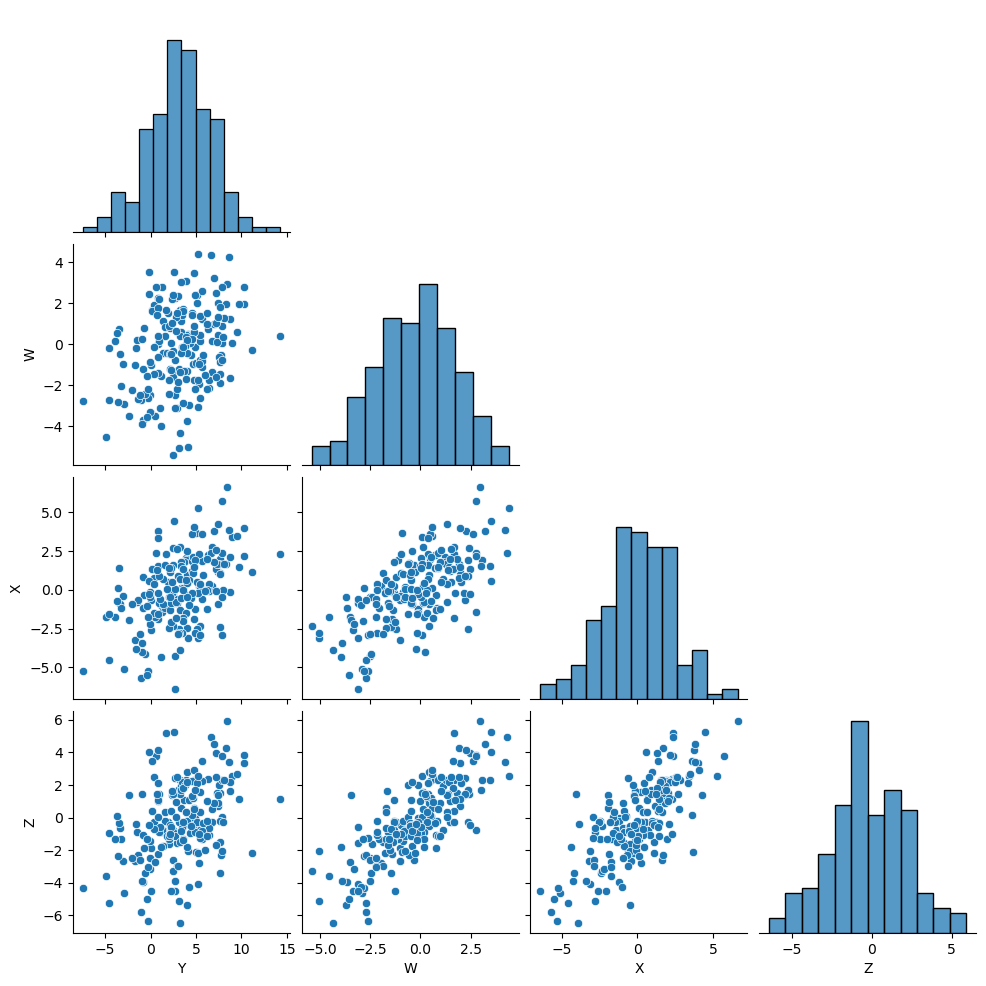

In [4]:
df = pd.DataFrame({
        "Y":Y, "W": X[:,0], "X": X[:,1], "Z": X[:,2]
    })
sns.pairplot(df, corner=True)
plt.show()

In [5]:
sm.OLS.from_formula("Y ~ 1", data=df).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      Y   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                  0.000
Method:                 Least Squares   F-statistic:                       nan
Date:                Sat, 27 Sep 2025   Prob (F-statistic):                nan
Time:                        17:45:48   Log-Likelihood:                -531.73
No. Observations:                 200   AIC:                             1065.
Df Residuals:                     199   BIC:                             1069.
Df Model:                           0                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      3.2597      0.245     13.311      0.000       2.777       3.743
==============================================================================
Omnibus:                        1.118   Durbin-Watson:                   2.071
Prob(Omnibus):                  0.572   Jarque-Bera (JB):                0.816
Skew:                          -0.134   Prob(JB):                        0.665
Kurtosis:                       3.162   Cond. No.                         1.00
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

Let's now define the forward stepwise selection procedure (modified from https://ujangriswanto08.medium.com/mastering-stepwise-linear-regression-in-python-from-theory-to-practice-d7293d635240).

In [6]:
def forward_selection(X, y, verbose=False):
    selected_features = []
    remaining_features = list(X.columns)
    model = sm.OLS.from_formula("Y ~ 1", data=pd.DataFrame({"Y": y})).fit() # null model, intercept only
    best_aic = model.aic

    if verbose: print("------------ START -------------")
    while remaining_features:
        if verbose: print(f"Selected features:  {selected_features}")
        if verbose: print(f"Remaining features: {remaining_features}")
        aic_with_candidates = []
        
        for candidate in remaining_features:
            model = sm.OLS(y, sm.add_constant(X[selected_features + [candidate]])).fit()
            if verbose: print(f"  AIC of {candidate}: {model.aic}")
            aic_with_candidates.append((model.aic, candidate))
        
        aic_with_candidates.sort()  # Sort by AIC
        best_new_aic, best_candidate = aic_with_candidates[0]
        if verbose: print(f"    Best: {best_candidate} (AIC: {best_new_aic})")

        if best_new_aic < best_aic:
            if verbose: print("    BEST NEW AIC less than PREVIOUS")
            best_aic = best_new_aic
            selected_features.append(best_candidate)
            remaining_features.remove(best_candidate)
        else:
            if verbose: print("    BEST NEW AIC greater than PREVIOUS")
            break
    if verbose: print(f"SELECTED MODEL: {selected_features}")
    if verbose: print("------------ END -------------")
    return selected_features

Let's now start the simulation, collecting: 

- the parameter estimates for each selected model and for the preferred model
- the t-test statistics for each selected model and for the preferred model
- the $R^2$ coefficient of determination for each selected model and for the preferred model

We'll set a seed for each drawing to ensure reproducibility.

Notice we do not (and we do not need nor want to) take other samples of the predictors: the predictors are not random variables, they're fixed and known without errors. $\pmb Y$ is a random variable, because of the identically and independently distributed random errors $\pmb \varepsilon$.

In [7]:
# samples numnber
rep = 10000
# init results
models = {
    "beta_0": [],
    "beta_w": [],
    "beta_x": [],
    "beta_z": [],
    "tval_0": [],
    "tval_W": [],
    "tval_X": [],
    "tval_Z": [],
    "R2": []
}
pref_model = {
    "beta_0": [],
    "beta_w": [],
    "beta_x": [],
    "beta_z": [],
    "tval_0": [],
    "tval_W": [],
    "tval_X": [],
    "tval_Z": [],
    "R2": []
}
# simulation
for i in tqdm(range(rep)):
    # draw a sample of Y given equation (1)
    Y = beta0 + betaw*X[:,0] + betax*X[:,1] + betaz*X[:,2] + epsilon.rvs(N, random_state=i)
    df = pd.DataFrame({
        "Y":Y, "W": X[:,0], "X": X[:,1], "Z": X[:,2]
    })
    x = df.drop('Y', axis=1)  # Features
    y = df['Y']               # Target variable
    # forward stepwise model selection
    selected_features = forward_selection(x, y)
    # selected model
    mod = sm.OLS.from_formula("Y ~ " + " + ".join(selected_features), data=df).fit()
    # collect t-test statistics and R-squared
    models["tval_0"].append(mod.tvalues.Intercept)
    models["beta_0"].append(mod.params.Intercept)
    if "W" in selected_features:
        models["tval_W"].append(mod.tvalues.W)
        models["beta_w"].append(mod.params.W)
    else:
        models["tval_W"].append(None)
        models["beta_w"].append(None)
    if "X" in selected_features:
        models["tval_X"].append(mod.tvalues.X)
        models["beta_x"].append(mod.params.X)
    else:
        models["tval_X"].append(None)
        models["beta_x"].append(None)
    if "Z" in selected_features:
        models["tval_Z"].append(mod.tvalues.Z)
        models["beta_z"].append(mod.params.Z)
    else:
        models["tval_Z"].append(None)
        models["beta_z"].append(None)
    models["R2"].append(mod.rsquared)
    # preferred model
    mod = sm.OLS.from_formula("Y ~ X + Z", data=df).fit()
    # collect t-test statistics and R-squared
    pref_model["beta_0"].append(mod.params.Intercept)
    pref_model["beta_w"].append(0)
    pref_model["beta_x"].append(mod.params.X)
    pref_model["beta_z"].append(mod.params.Z)
    pref_model["tval_0"].append(mod.tvalues.Intercept)
    pref_model["tval_W"].append(None)
    pref_model["tval_X"].append(mod.tvalues.X)
    pref_model["tval_Z"].append(mod.tvalues.Z)
    pref_model["R2"].append(mod.rsquared)

  0%|          | 0/10000 [00:00<?, ?it/s]

# RESULTS

Let's define `DataFrame`s of the results.

In [8]:
DF = pd.DataFrame(models)
DF

,beta_0,beta_w,beta_x,beta_z,tval_0,tval_W,tval_X,tval_Z,R2
0,3.169103,NaN,0.799259,NaN,13.826077,NaN,7.893012,NaN,0.239338
1,3.345725,NaN,0.562954,0.296167,16.229723,NaN,4.190811,2.333006,0.296420
2,2.983097,NaN,0.831783,NaN,12.314385,NaN,7.772268,NaN,0.233770
3,2.790740,NaN,0.371895,0.312442,12.598831,NaN,2.576535,2.290543,0.188186
4,3.097826,NaN,0.458884,0.284329,14.293268,NaN,3.249242,2.130368,0.221719
...,...,...,...,...,...,...,...,...,...
9995,2.812930,0.324123,0.511066,NaN,13.861434,2.432771,4.357169,NaN,0.257323
9996,3.271990,NaN,0.792126,NaN,14.238254,NaN,7.802465,NaN,0.235162
9997,3.055682,NaN,0.312665,0.467548,14.457266,NaN,2.270188,3.592212,0.253002
9998,2.936045,-0.489106,0.470383,0.533586,12.901509,-2.557695,3.150431,2.988573,0.193585


In [9]:
PR = pd.DataFrame(pref_model)
PR

,beta_0,beta_w,beta_x,beta_z,tval_0,tval_W,tval_X,tval_Z,R2
0,3.199795,0,0.686942,0.143339,13.838559,None,4.559251,1.006677,0.243231
1,3.345725,0,0.562954,0.296167,16.229723,None,4.190811,2.333006,0.296420
2,3.017846,0,0.704619,0.162286,12.354168,None,4.426652,1.078837,0.238271
3,2.790740,0,0.371895,0.312442,12.598831,None,2.576535,2.290543,0.188186
4,3.097826,0,0.458884,0.284329,14.293268,None,3.249242,2.130368,0.221719
...,...,...,...,...,...,...,...,...,...
9995,2.774681,0,0.544966,0.195865,13.617626,None,4.104519,1.561003,0.244358
9996,3.308836,0,0.657289,0.172080,14.289310,None,4.356090,1.206768,0.240775
9997,3.055682,0,0.312665,0.467548,14.457266,None,2.270188,3.592212,0.253002
9998,2.995953,0,0.411216,0.248246,13.052719,None,2.749417,1.756334,0.166670


Let's plot the distribution (KDE) of $R^2$ for both the selected models and the preferred model.

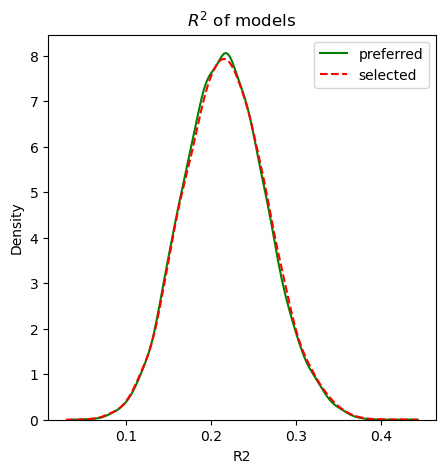

In [10]:
fig, ax = plt.subplots(figsize=(5, 5))
sns.kdeplot(PR.R2, label="preferred", color="g")
sns.kdeplot(DF.R2, label="selected", color="r", ls="--")
plt.legend()
plt.title("$R^2$ of models")
plt.show()

Although quite poor, we do not care here for the value itself but for the distribution.

We can clearly see that the coefficient of determinations are likely very similar. We could also perform a two-samples Kolmogorov-Smirnov test to test the null hypothesis that the two samples have been drawn from the same distribution.

In [11]:
sps.ks_2samp(DF.R2, PR.R2, nan_policy="raise", alternative="two-sided")

KstestResult(statistic=0.0115, pvalue=0.5228883388356883, statistic_location=0.2527124260028467, statistic_sign=-1)

Indeed, the $p$-value is $\gg .10$ so we fail to reject the null hypothesis. This confirms the visual inspection.

Let's now compute the absolute and relative frequencies of the 8 possible models, selected by the forward stepwise procedure.

In [12]:
perc_selection = pd.DataFrame({
    "null": [DF[(DF.tval_W.isna())&(DF.tval_X.isna())&(DF.tval_Z.isna())].index.size],
    "W": [DF[(~DF.tval_W.isna())&(DF.tval_X.isna())&(DF.tval_Z.isna())].index.size],
    "X": [DF[(DF.tval_W.isna())&(~DF.tval_X.isna())&(DF.tval_Z.isna())].index.size],
    "Z": [DF[(DF.tval_W.isna())&(DF.tval_X.isna())&(~DF.tval_Z.isna())].index.size],
    "WX": [DF[(~DF.tval_W.isna())&(~DF.tval_X.isna())&(DF.tval_Z.isna())].index.size],
    "WZ": [DF[(~DF.tval_W.isna())&(DF.tval_X.isna())&(~DF.tval_Z.isna())].index.size],
    "XZ": [DF[(DF.tval_W.isna())&(~DF.tval_X.isna())&(~DF.tval_Z.isna())].index.size],
    "WXZ": [DF[(~DF.tval_W.isna())&(~DF.tval_X.isna())&(~DF.tval_Z.isna())].index.size]
})
perc_selection.style.hide(axis="index").set_caption("SELECTED MODELS ABSOLUTE FREQUENCIES")

null,W,X,Z,WX,WZ,XZ,WXZ
0,5,2974,192,1296,47,4852,634


In [13]:
perc_selection = pd.DataFrame({
    "null": [DF[(DF.tval_W.isna())&(DF.tval_X.isna())&(DF.tval_Z.isna())].index.size/rep],
    "W": [DF[(~DF.tval_W.isna())&(DF.tval_X.isna())&(DF.tval_Z.isna())].index.size/rep],
    "X": [DF[(DF.tval_W.isna())&(~DF.tval_X.isna())&(DF.tval_Z.isna())].index.size/rep],
    "Z": [DF[(DF.tval_W.isna())&(DF.tval_X.isna())&(~DF.tval_Z.isna())].index.size/rep],
    "WX": [DF[(~DF.tval_W.isna())&(~DF.tval_X.isna())&(DF.tval_Z.isna())].index.size/rep],
    "WZ": [DF[(~DF.tval_W.isna())&(DF.tval_X.isna())&(~DF.tval_Z.isna())].index.size/rep],
    "XZ": [DF[(DF.tval_W.isna())&(~DF.tval_X.isna())&(~DF.tval_Z.isna())].index.size/rep],
    "WXZ": [DF[(~DF.tval_W.isna())&(~DF.tval_X.isna())&(~DF.tval_Z.isna())].index.size/rep]
})
perc_selection.style.hide(axis="index").format('{:.2%}').set_caption("SELECTED MODELS RELATIVE FREQUENCIES")

null,W,X,Z,WX,WZ,XZ,WXZ
0.00%,0.05%,29.74%,1.92%,12.96%,0.47%,48.52%,6.34%


We see that

- the preferred model has been selected approx. $49\%$ of the times

- the null model has never been selected

- the full model has been selected approx. $6\%$ of the times

- respectively, approx. $30\%$ and $13\%$ of the times, models with $X$ and with both $X$ and $W$ have been selected

- other models (with $W$, with $Z$, and with $WZ$) have been selected less than $2\%$ of times

Let's take a look at the relative frequencies of each predictor having been included in the selected model.

In [20]:
perc_predictor = pd.DataFrame({
    "W": [DF[(~DF.tval_W.isna())].index.size/rep],
    "X": [DF[(~DF.tval_X.isna())].index.size/rep],
    "Z": [DF[(~DF.tval_Z.isna())].index.size/rep],
})
perc_predictor.style.hide(axis="index").format('{:.2%}').set_caption("INCLUDED PREDICTORS RELATIVE FREQUENCIES")

W,X,Z
19.82%,97.56%,57.25%


Notice that the predictor $W$ has been included a non-zero percentage of the times (approx. $20\%$...!), even if we know that the "true" value of $\beta_w$ is null.

Let's now plot the distributions (KDE) of the parameters' estimates for both the preferred and the selected models.

For the selected models, the distributions for each predictor's parameter are conditional on the predictor having been included in the selected model.

/var/folders/b5/91v33kb942vd3xw6d7cgsgbm0000gn/T/ipykernel_96726/1673371828.py:12: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  sns.kdeplot(PR.beta_w, label="preferred", color="g", ax=ax[1,0])


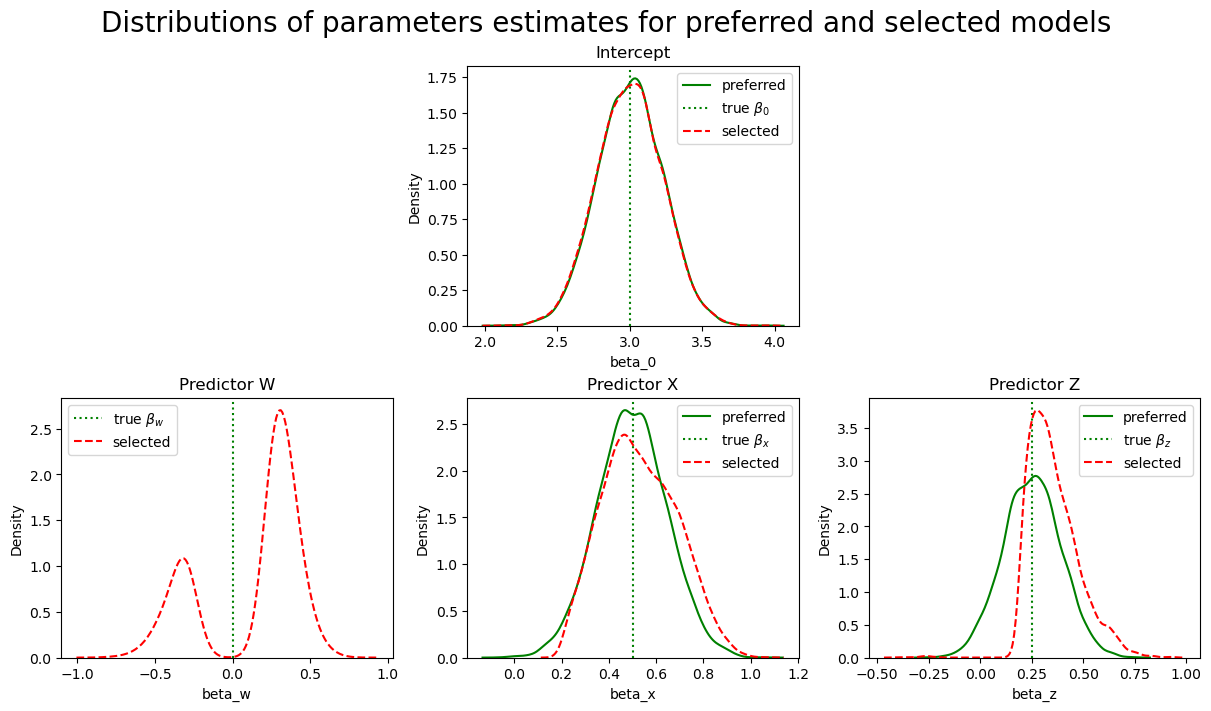

In [15]:
fig, ax = plt.subplots(2, 3, figsize=(12, 7), layout="constrained")

ax[0,0].axis(False)
ax[0,2].axis(False)

sns.kdeplot(PR.beta_0, label="preferred", color="g", ax=ax[0,1])
ax[0,1].axvline(beta0, color="g", ls=":", label=r"true $\beta_0$")
sns.kdeplot(DF.beta_0, label="selected", color="r", ls="--", ax=ax[0,1])
ax[0,1].legend()
ax[0,1].set_title("Intercept")

sns.kdeplot(PR.beta_w, label="preferred", color="g", ax=ax[1,0])
ax[1,0].axvline(betaw, color="g", ls=":", label=r"true $\beta_w$")
sns.kdeplot(DF.beta_w, label="selected", color="r", ls="--", ax=ax[1,0])
ax[1,0].legend()
ax[1,0].set_title("Predictor W")

sns.kdeplot(PR.beta_x, label="preferred", color="g", ax=ax[1,1])
ax[1,1].axvline(betax, color="g", ls=":", label=r"true $\beta_x$")
sns.kdeplot(DF.beta_x, label="selected", color="r", ls="--", ax=ax[1,1])
ax[1,1].legend()
ax[1,1].set_title("Predictor X")

sns.kdeplot(PR.beta_z, label="preferred", color="g", ax=ax[1,2])
ax[1,2].axvline(betaz, color="g", ls=":", label=r"true $\beta_z$")
sns.kdeplot(DF.beta_z, label="selected", color="r", ls="--", ax=ax[1,2])
ax[1,2].legend()
ax[1,2].set_title("Predictor Z")

fig.suptitle("Distributions of parameters estimates for preferred and selected models", fontsize=20)

plt.show()

We notice that

- we do not have any distribution for predictor $W$ in the preferred model, since it wasn't included, but we have a bimodal distribution for $W$ in the selected models since it has been selected approx. $20\%$ of times

- the distribution for $X$ seems 'enough' normal for the preferred model, but it doesn't seem normal for the selected models

- the distribution for $Z$ seems 'enough' normal for the preferred model, but it looks truncated and less normally distributed for the selected models

We could also perform Anderson-Darling tests to test the null hypothesis that the observed parameters' estimates have been drawn from a normal distribution.

In [16]:
sps.anderson(PR.beta_x), sps.anderson(PR.beta_z)

(AndersonResult(statistic=0.2228119111732667, critical_values=array([0.576, 0.656, 0.787, 0.918, 1.092]), significance_level=array([15. , 10. ,  5. ,  2.5,  1. ]), fit_result=  params: FitParams(loc=0.4983240054919164, scale=0.1472719400395057)
  success: True
  message: '`anderson` successfully fit the distribution to the data.'),
 AndersonResult(statistic=0.4018049441383482, critical_values=array([0.576, 0.656, 0.787, 0.918, 1.092]), significance_level=array([15. , 10. ,  5. ,  2.5,  1. ]), fit_result=  params: FitParams(loc=0.25152238994055764, scale=0.13960476241790787)
  success: True
  message: '`anderson` successfully fit the distribution to the data.'))

In [17]:
sps.anderson(DF.beta_w.dropna()), sps.anderson(DF.beta_x.dropna()), sps.anderson(DF.beta_z.dropna())

(AndersonResult(statistic=188.97568918089883, critical_values=array([0.575, 0.655, 0.785, 0.916, 1.09 ]), significance_level=array([15. , 10. ,  5. ,  2.5,  1. ]), fit_result=  params: FitParams(loc=0.13399312839760247, scale=0.3220108922900787)
  success: True
  message: '`anderson` successfully fit the distribution to the data.'),
 AndersonResult(statistic=24.85454571869741, critical_values=array([0.576, 0.656, 0.787, 0.918, 1.092]), significance_level=array([15. , 10. ,  5. ,  2.5,  1. ]), fit_result=  params: FitParams(loc=0.5317531019207572, scale=0.15654570621722505)
  success: True
  message: '`anderson` successfully fit the distribution to the data.'),
 AndersonResult(statistic=87.68360073057556, critical_values=array([0.576, 0.656, 0.786, 0.917, 1.091]), significance_level=array([15. , 10. ,  5. ,  2.5,  1. ]), fit_result=  params: FitParams(loc=0.35588097061774066, scale=0.12182491787797349)
  success: True
  message: '`anderson` successfully fit the distribution to the data.

We see that we reject the null hypothesis for all parameters' estimates of the selected models, and we fail to reject the null hypothesis for all parameters' estimates of the preferred model. This confirms what we visually suspected.

Let's now plot the distributions (KDE) of t-test statistics of each predictor for both the selected and the preferred model.

For the selected models, the distributions of the t-test statistics for each predictor's parameter are conditional on the predictor having been included in the selected model.

/var/folders/b5/91v33kb942vd3xw6d7cgsgbm0000gn/T/ipykernel_96726/2880685200.py:11: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  sns.kdeplot(PR.tval_W, label="preferred", color="g", ax=ax[1,0])


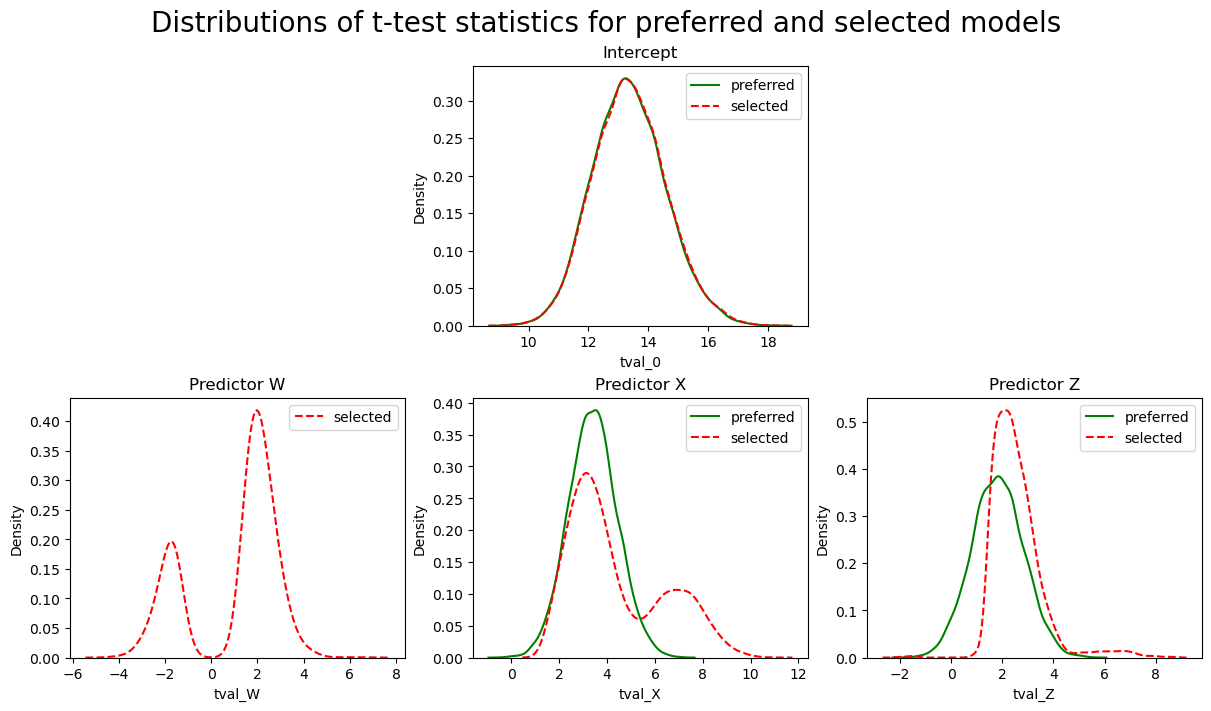

In [18]:
fig, ax = plt.subplots(2, 3, figsize=(12, 7), layout="constrained")

ax[0,0].axis(False)
ax[0,2].axis(False)

sns.kdeplot(PR.tval_0, label="preferred", color="g", ax=ax[0,1])
sns.kdeplot(DF.tval_0, label="selected", color="r", ls="--", ax=ax[0,1])
ax[0,1].legend()
ax[0,1].set_title("Intercept")

sns.kdeplot(PR.tval_W, label="preferred", color="g", ax=ax[1,0])
sns.kdeplot(DF.tval_W, label="selected", color="r", ls="--", ax=ax[1,0])
ax[1,0].legend()
ax[1,0].set_title("Predictor W")

sns.kdeplot(PR.tval_X, label="preferred", color="g", ax=ax[1,1])
sns.kdeplot(DF.tval_X, label="selected", color="r", ls="--", ax=ax[1,1])
ax[1,1].legend()
ax[1,1].set_title("Predictor X")

sns.kdeplot(PR.tval_Z, label="preferred", color="g", ax=ax[1,2])
sns.kdeplot(DF.tval_Z, label="selected", color="r", ls="--", ax=ax[1,2])
ax[1,2].legend()
ax[1,2].set_title("Predictor Z")

fig.suptitle("Distributions of t-test statistics for preferred and selected models", fontsize=20)

plt.show()

We can notice that

- we do not have any distribution for predictor $W$ in the preferred model, since it wasn't included, but we have a bimodal distribution for $W$ in the selected models since it has been included approx. $20\%$ of the times

- the distribution for $X$ for the selected models is definitely different from the preferred model, and clearly bimodal

- the distribution for $Z$ for the selected models is definitely different from the preferred model, and it looks truncated and bimodal

We could also perform a two-samples Kolmogorov-Smirnov test to test the null hypothesis that the samples (for $X$ and $Z$) have been drawn from the same distribution.

In [19]:
sps.ks_2samp(DF.tval_X.dropna(), PR.tval_X, nan_policy="raise"), sps.ks_2samp(DF.tval_Z.dropna(), PR.tval_Z, nan_policy="raise")

(KstestResult(statistic=0.2713779827798278, pvalue=2.4046e-320, statistic_location=5.400469963738213, statistic_sign=-1),
 KstestResult(statistic=0.3394943231441048, pvalue=1.3335e-320, statistic_location=1.4082367549284602, statistic_sign=-1))

In both cases, we definitely reject the null hypothesis. This confirms the visual inspection.

# CONCLUSIONS

As pointed out by Berk (2010) and many other Authors who have deeply studied the model selection bias, we have experimentally verified that the model selection procedure distorts the estimators' distributions, invalidating the classical inference on the selected model.

This happens because, as a result of the model selection procedure, the model itself is not "fixed" anymore but becomes a random variable itself (Berk 2013), potentially having dramatic effects on the estimators' distributions, as in the simulation we performed.

I hope that this simulation can help other Students and Scholars understand the complex topic of _model selection bias_.

# ESSENTIAL BIBLIOGRAPHY

Berk, R., Brown, L., & Zhao, L. (2010). Statistical inference after model selection. _Journal of Quantitative Criminology, 26(2)_, 217-236.

Berk, R., Brown, L., Buja, A., Zhang, K., & Zhao, L. (2013). Valid post-selection inference. _The Annals of Statistics_, 802-837.

Leeb, H., & Pötscher, B. M. (2005). Model selection and inference: Facts and fiction. _Econometric Theory, 21(1)_, 21-59.

Pötscher, B. M. (1991). Effects of model selection on inference. _Econometric Theory, 7(2)_, 163-185.

Many other papers, even more recent, can be found in the literature. A Bayesian simulation can be found at https://josue.rbind.io/post/model-selection-bias/.